In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import pandas as pd

In [2]:
file = '/home/kei/Escritorio/cats/SHELA_P12_N419_allband_merged_cat_feb2024.fits'
hdul = fits.open(file)
tabla = Table(hdul['LDAC_OBJECTS'].data)

In [3]:
# Extraer MAG_APER y MAGERR_APER, y quedarnos con la columna 3, las cuales corresponden a N419 (índice 3)
tabla['MAG_APER_3'] = np.array(tabla['MAG_APER'].tolist())[:, 3]
tabla['MAGERR_APER_3'] = np.array(tabla['MAGERR_APER'].tolist())[:, 3]
tabla['FLUX_RADIUS_3'] = np.array(tabla['FLUX_RADIUS'].tolist())[:, 2]

In [4]:
# Filtrar solo columnas de una dimensión para pasar a pandas
colfilt = [col for col in tabla.colnames if len(tabla[col].shape) <= 1]
tabla = tabla[colfilt]


In [5]:
# Columnas necesarias para análisis
cols_necesarias = [
    'NUMBER', 'X_WORLD', 'Y_WORLD',
    'MAG_AUTO_G', 'MAGERR_AUTO_G', 'MAG_AUTO_R', 'MAGERR_AUTO_R',
    'MAG_APER_3', 'MAGERR_APER_3',
    'FLUX_AUTO_G', 'FLUXERR_AUTO_G', 'FLUX_AUTO_R', 'FLUXERR_AUTO_R',
    'IMAFLAGS_ISO', 'FLAGS', 'CLASS_STAR',
    'ELLIPTICITY', 'KRON_RADIUS', 'FWHM_WORLD', 'FLUX_RADIUS_3'
]

df = tabla[cols_necesarias].to_pandas()
print("Total de filas antes del modelo híbrido:", len(df))


Total de filas antes del modelo híbrido: 431525


In [6]:
# --- Aplicar cortes de calidad ---
# 1. FLUX ≠ 0 y MAGERR_APER ≠ 0
df['cond1'] = (df['FLUX_AUTO_G'] != 0)
df['cond2'] = (df['FLUX_AUTO_R'] != 0)
df['cond3'] = (df['MAGERR_APER_3'] != 0)

# 2. S/N > 5 para MAG_APER_3
df['cond4'] = (1.0869 / df['MAGERR_APER_3']) >= 5.

# 3. IMAFLAGS_ISO = 0
df['cond5'] = (df['IMAFLAGS_ISO'] == 0.0)

# 4. FLAGS < 4
df['cond6'] = (df['FLAGS'] < 4.0)

# Revisar cuántas cumplen cada condición
for i in range(1, 7):
    print(f'Condición {i}:')
    print(df[f'cond{i}'].value_counts(), '\n')

Condición 1:
cond1
True     431162
False       363
Name: count, dtype: int64 

Condición 2:
cond2
True     431212
False       313
Name: count, dtype: int64 

Condición 3:
cond3
True    431525
Name: count, dtype: int64 

Condición 4:
cond4
True     412590
False     18935
Name: count, dtype: int64 

Condición 5:
cond5
True     428826
False      2699
Name: count, dtype: int64 

Condición 6:
cond6
True     430301
False      1224
Name: count, dtype: int64 



In [7]:
# Aplicar cortes adicionales de magnitud
df['cortegmax'] = df['MAG_AUTO_G'] <= 30.0
df['corteerg']  = df['MAGERR_AUTO_G'] > 0.0
df['corteg99']  = df['MAG_AUTO_G'] < 99.0
df['cortermax'] = df['MAG_AUTO_R'] <= 30.0
df['corteerr']  = df['MAGERR_AUTO_R'] > 0.0
df['corter99']  = df['MAG_AUTO_R'] < 99.0

# Conteos
for corte in ['cortegmax', 'corteerg', 'corteg99', 'cortermax', 'corteerr', 'corter99']:
    print(f'{corte}:')
    print(df[corte].value_counts(), '\n')


cortegmax:
cortegmax
True     425399
False      6126
Name: count, dtype: int64 

corteerg:
corteerg
True    431525
Name: count, dtype: int64 

corteg99:
corteg99
True     426977
False      4548
Name: count, dtype: int64 

cortermax:
cortermax
True     425159
False      6366
Name: count, dtype: int64 

corteerr:
corteerr
True    431525
Name: count, dtype: int64 

corter99:
corter99
True     426896
False      4629
Name: count, dtype: int64 



In [8]:
df['calidad_total'] = df[[f'cond{i}' for i in range(1, 7)] + [
    'cortegmax', 'corteerg', 'corteg99',
    'cortermax', 'corteerr', 'corter99'
]].all(axis=1)
df_filtrado = df[df['calidad_total']]
print(f'Número final de objetos tras cortes: {len(df_filtrado)}')


Número final de objetos tras cortes: 405826


In [9]:
# Parámetro w419 según Firestone (Tabla 2)
w419 = -0.438 

In [25]:
#forma profe pauli
import numpy as np
import math

def compute_rg(row):
    # Verifica que no haya divisores cero antes de evaluar S/N
    if row['FLUXERR_AUTO_R'] > 0 and row['FLUXERR_AUTO_G'] > 0:
        snr_r = row['FLUX_AUTO_R'] / row['FLUXERR_AUTO_R']
        snr_g = row['FLUX_AUTO_G'] / row['FLUXERR_AUTO_G']
    else:
        snr_r, snr_g = 0, 0  # fuerza a pasar por el else

    if snr_r >= 3 and snr_g >= 3:
        row['rg_mag'] = w419 * row['MAG_AUTO_R'] + (1 - w419) * row['MAG_AUTO_G']
        row['rg_merr'] = np.sqrt((w419 * row['MAGERR_AUTO_R'])**2 + ((1 - w419) * row['MAGERR_AUTO_G'])**2)
    else:
        row['rg_flux'] = w419 * row['FLUX_AUTO_R'] + (1 - w419) * row['FLUX_AUTO_G']
        if row['rg_flux'] > 0:
            row['rg_mag'] = -2.5 * np.log10(row['rg_flux'])
            denom = row['rg_flux']
            # Para evitar dividir por cero accidental
            if denom == 0:
                row['rg_merr'] = np.nan
            else:
                row['rg_merr'] = (2.5 / math.log(10)) * np.sqrt(
                    (w419 * row['FLUXERR_AUTO_R'])**2 + ((1 - w419) * row['FLUXERR_AUTO_G'])**2
                ) / denom
        else:
            row['rg_mag'] = np.nan
            row['rg_merr'] = np.nan
    return row

df = df.apply(compute_rg, axis=1)


In [9]:
#calculo mío
# Calcular S/N para bandas G y R
df['SN_G'] = df['FLUX_AUTO_G'] / df['FLUXERR_AUTO_G']
df['SN_R'] = df['FLUX_AUTO_R'] / df['FLUXERR_AUTO_R']

# Crear máscaras según el S/N
grupo_mag = (df['SN_G'] >= 3) & (df['SN_R'] >= 3)
grupo_flux = ~grupo_mag  # los que tienen S/N < 3 en al menos una banda

# Inicializar columnas
df['rg_mag'] = np.nan
df['rg_err'] = np.nan
df['rg_flux'] = np.nan  # solo se usará para el grupo de flujos

# --- Grupo 1: usar modelo de magnitudes (power law) ---
df.loc[grupo_mag, 'rg_mag'] = (
    w419 * df.loc[grupo_mag, 'MAG_AUTO_R'] + (1 - w419) * df.loc[grupo_mag, 'MAG_AUTO_G']
)
df.loc[grupo_mag, 'rg_err'] = np.sqrt(
    (w419 * df.loc[grupo_mag, 'MAGERR_AUTO_R'])**2 +
    ((1 - w419) * df.loc[grupo_mag, 'MAGERR_AUTO_G'])**2
)

# --- Grupo 2: usar modelo de flujos (linear) ---
df.loc[grupo_flux, 'rg_flux'] = (
    w419 * df.loc[grupo_flux, 'FLUX_AUTO_R'] + (1 - w419) * df.loc[grupo_flux, 'FLUX_AUTO_G']
)

# Eliminar posibles flujos negativos o nulos antes de usar log10
df = df[df['rg_flux'].isna() | (df['rg_flux'] > 0)]

# Calcular rg_mag y rg_err solo donde rg_flux > 0
grupo_flux_valid = grupo_flux & (df['rg_flux'] > 0)

df.loc[grupo_flux_valid, 'rg_mag'] = -2.5 * np.log10(df.loc[grupo_flux_valid, 'rg_flux'])
df.loc[grupo_flux_valid, 'rg_err'] = (
    (2.5 / np.log(10)) *
    (np.sqrt(
        (w419 * df.loc[grupo_flux_valid, 'FLUXERR_AUTO_R'])**2 +
        ((1 - w419) * df.loc[grupo_flux_valid, 'FLUXERR_AUTO_G'])**2
    ) / df.loc[grupo_flux_valid, 'rg_flux'])
)



In [11]:
from astropy.io import ascii
t419txt= ascii.read('/home/kei/Escritorio/cats/N419_simulated_transmission_f3.6.txt')
t419 = t419txt.to_pandas()
#cargamos la data de las broadbans g,r,i,z,Y:

#BBtxt = ascii.read('/Users/pauly/Downloads/broadbands.txt')
BBtxt = ascii.read('/home/kei/Escritorio/cats/broadbands.txt')
#conversion de la "tabla" a un DataFrame de Pandas para poder utilizar función apply
BB = BBtxt.to_pandas()

#LAMBDA estaba en angstrom y los filtros son adiminesionales 
BB['wave'] = BB['LAMBDA']*(0.1)

w419 = -0.437677# Peso
#BB['gr'] = BB.apply(lambda row: w * row['g'] + (1 - w) * row['r'], axis=1)  # Transmisión

BB['rg'] = BB.apply(lambda row: w419 * row['r'] + (1 - w419) * row['g'], axis=1)  # Transmisión

#BB

In [12]:
import scipy.integrate as integrate
from scipy.integrate import quad
def integrand(x, c, T_BB):
    return (c * T_BB) / (x**2)

a, b = 400, 480
c = 3 * 10**14
integrals_quad = []
errors_quad = []

for index, row in BB.iterrows():
    integral, error = quad(integrand, a, b, args=(c, row['rg']))
    integrals_quad.append(integral)
    errors_quad.append(error)
    
BB['area'] = integrals_quad
BB['error'] = errors_quad
area_rg = BB['area'].sum()
total_error_rg = np.sqrt(np.sum(np.array(errors_quad)**2))
print("El área total bajo la curva es:", area_rg)
print("El error total estimado es:", total_error_rg)

El área total bajo la curva es: 14741513790113.75
El error total estimado es: 0.019779632053444626


In [13]:
wave = t419['Wavelength[nm]']
T = t419['Transmission']

def integrand(x, c, T):
    return (c * T) / (x**2)

a, b = 400, 480
c = 3 * 10**14
integrals_quad = []
errors_quad = []

for index, row in t419.iterrows():
    integral, error = quad(integrand, a, b, args=(c, row['Transmission']))
    integrals_quad.append(integral)
    errors_quad.append(error)
    
t419['area'] = integrals_quad
t419['error'] = errors_quad
area_n419 = t419['area'].sum()
total_error_n419 = np.sqrt(np.sum(np.array(errors_quad)**2))
print("El área total bajo la curva es:", area_n419)
print("El error total estimado es:", total_error_n419)

El área total bajo la curva es: 4584035245000.0
El error total estimado es: 0.0076973615891856376


In [14]:
C = area_n419 / area_rg
C

0.3109609576239204

In [16]:
# Condición 1: exceso de banda estrecha mínimo
df['condition1'] = (df['rg_mag'] - df['MAG_APER_3']) >= 0.71

# Condición 2: exceso mayor que 3σ
df['sigma_err'] = np.sqrt(df['rg_merr']**2 + df['MAGERR_APER_3']**2)
df['condition2'] = (df['rg_mag'] - df['MAG_APER_3']) >= (3 * df['sigma_err'])


# Condición 3: brillo comparable a una línea de emisión pura
df['condition3'] = (df['rg_mag'] - df['MAG_APER_3']) < (-2.5 * np.log10(C) + 2 * df['sigma_err'])

# Condición 4: radio efectivo menor que 1.38 arcsec
pixel_scale = 0.168  # arcsec/pixel (valor común para HSC)

# Convertir R50 de pix a arcsec
df['FLUX_RADIUS_3_ARC'] = df['FLUX_RADIUS_3'] * pixel_scale

# Aplicar la condición 4: R50 < 1.38 arcsec
df['condition4'] = df['FLUX_RADIUS_3_ARC'] < 1.38

# Condición 5: magnitud en banda estrecha mayor o igual a 20
df['condition5'] = df['MAG_APER_3'] >= 20

# Condición 6: magnitud en banda estrecha menor que el límite 5σ (25.5 para N419)
df['condition6'] = df['MAG_APER_3'] < 25.5

# Imprimir conteos
for cond in ['condition1', 'condition2', 'condition3', 'condition4', 'condition5', 'condition6']:
    print(f'{cond}:')
    print(df[cond].value_counts(), '\n')

condition1:
condition1
False    421655
True       9870
Name: count, dtype: int64 

condition2:
condition2
False    425709
True       5816
Name: count, dtype: int64 

condition3:
condition3
True     425576
False      5949
Name: count, dtype: int64 

condition4:
condition4
True     395697
False     35828
Name: count, dtype: int64 

condition5:
condition5
True     426105
False      5420
Name: count, dtype: int64 

condition6:
condition6
True     412403
False     19122
Name: count, dtype: int64 



In [17]:
df['color_rg_n419'] = df['rg_mag'] - df['MAG_APER_3']

In [18]:
# Combinar todos los cortes y condiciones
cortes_calidad = df[[f'cond{i}' for i in range(1, 7)]].all(axis=1)
cortes_magnitud = df[['cortegmax', 'corteerg', 'corteg99', 'cortermax', 'corteerr', 'corter99']].all(axis=1)
condiciones_seleccion = df[[f'condition{i}' for i in range(1, 7)]].all(axis=1)

# Seleccionar solo los que cumplen todo
selection_1 = df[cortes_calidad & cortes_magnitud & condiciones_seleccion]

# Ver cuántos hay
print(f'Total de candidatos LAEs seleccionados: {len(selection_1)}')


Total de candidatos LAEs seleccionados: 2341


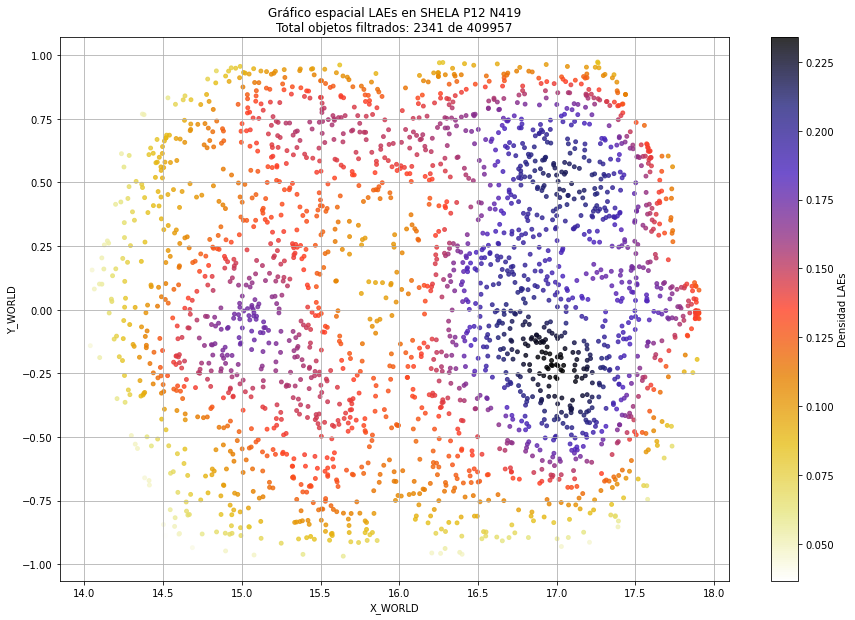

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import numpy as np

# Extraer coordenadas
x = selection_1['X_WORLD']
y = selection_1['Y_WORLD']

# Calcular densidad
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Contar objetos seleccionados
num_objects = len(selection_1)

# Crear figura
plt.figure(figsize=(15, 10))
scatter = plt.scatter(x, y, c=z, s=15, marker='o', cmap='CMRmap_r', alpha=0.8, edgecolor='face')
plt.colorbar(scatter, label='Densidad LAEs')
plt.xlabel('X_WORLD')
plt.ylabel('Y_WORLD')
plt.title(f'Gráfico espacial LAEs en SHELA P12 N419\nTotal objetos filtrados: {num_objects} de 409957')
plt.grid(True)

# Puedes activar los límites si deseas enfocar una región específica
# plt.xlim(16.3, 17.3)
# plt.ylim(-0.50, 0.23)

plt.show()


In [20]:
cat= pd.read_csv('/home/kei/Escritorio/cats/LAE_catalog_SHELA_P12_rg-n419_SE_2024_09_19_expanded.csv')

In [21]:
from astropy.coordinates import SkyCoord
from astropy import units as u

# Crear objetos SkyCoord para ambos catálogos
coords_selection = SkyCoord(ra=selection_1['X_WORLD'].values * u.deg, 
                            dec=selection_1['Y_WORLD'].values * u.deg)

coords_cat = SkyCoord(ra=cat['RA'].values * u.deg, 
                      dec=cat['DEC'].values * u.deg)

# Cruzar catálogos por coordenadas: para cada objeto en cat, buscar el más cercano en selection_1
idx, d2d, _ = coords_cat.match_to_catalog_sky(coords_selection)

# Establecer un umbral (por ejemplo, 1 arcsec)
mask = d2d < 1 * u.arcsec

# Obtener coincidencias
cat_matched = cat[mask].copy()
selection_matched = selection_1.iloc[idx[mask]].copy()

# Verificar cuántas coincidencias hay
print(f'Número de coincidencias dentro de 1 arcsec: {len(cat_matched)}')

Número de coincidencias dentro de 1 arcsec: 731


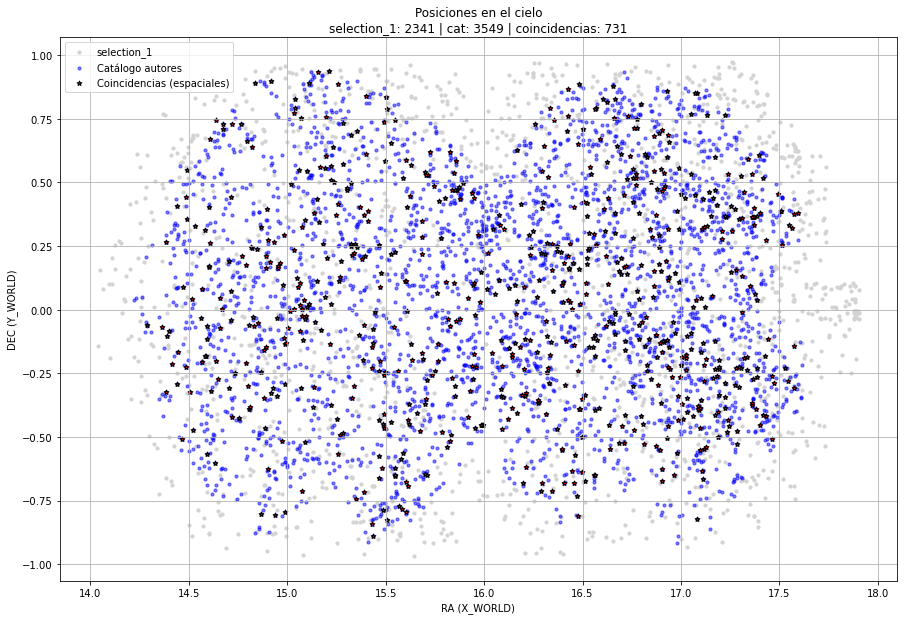

In [22]:
from astropy.coordinates import SkyCoord
from astropy import units as u

# Crear objetos SkyCoord para ambos catálogos
coords_selection = SkyCoord(ra=selection_1['X_WORLD'].values * u.deg, 
                            dec=selection_1['Y_WORLD'].values * u.deg)

coords_cat = SkyCoord(ra=cat['RA'].values * u.deg, 
                      dec=cat['DEC'].values * u.deg)

# Cruzar catálogos por coordenadas: para cada objeto en cat, buscar el más cercano en selection_1
idx, d2d, _ = coords_cat.match_to_catalog_sky(coords_selection)

# Establecer un umbral (por ejemplo, 1 arcsec)
mask = d2d < 1 * u.arcsec

# Obtener coincidencias
cat_matched = cat[mask].copy()
selection_matched = selection_1.iloc[idx[mask]].copy()

# Verificar cuántas coincidencias hay
print(f'Número de coincidencias dentro de 1 arcsec: {len(cat_matched)}')

In [23]:
# Normalizar a tipo entero, por si acaso
selection_ids = set(selection_1['NUMBER'].astype(int))
cat_ids = set(cat['index'].astype(int))

# Intersección
common_ids = selection_ids.intersection(cat_ids)

print(f'Número de coincidencias exactas por ID (NUMBER vs index): {len(common_ids)}')


Número de coincidencias exactas por ID (NUMBER vs index): 28


In [24]:
# Normalizar a tipo entero, por si acaso
df_all = set(df['NUMBER'].astype(int))
cat_ids = set(cat['index'].astype(int))

# Intersección
common_ids_all = df_all.intersection(cat_ids)

print(f'Número de coincidencias exactas por ID (NUMBER vs index): {len(common_ids_all)}')


Número de coincidencias exactas por ID (NUMBER vs index): 1672


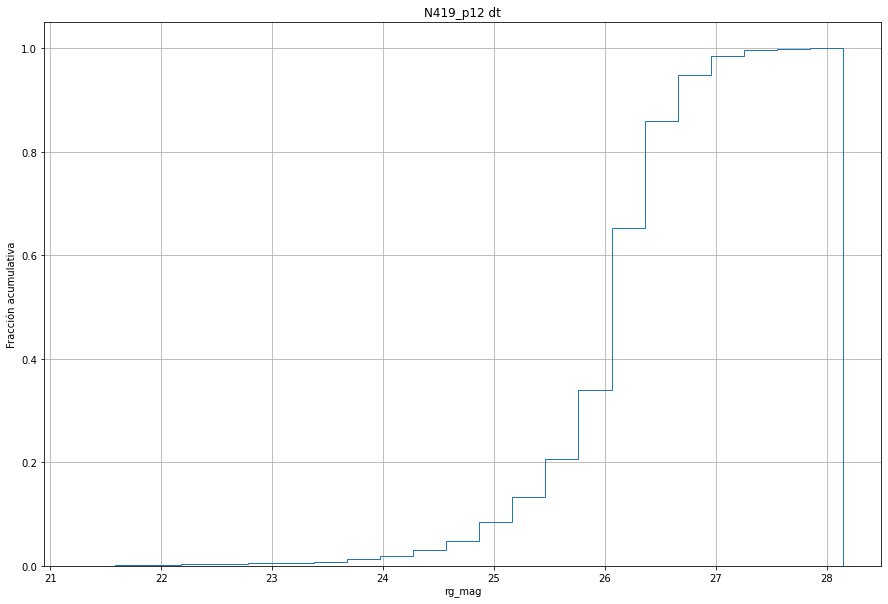

In [23]:
from astropy.stats import histogram
#N419_P12
mag_gr = selection_1['rg_mag']

plt.figure(figsize=(15, 10))
bins, bin_edges = histogram(mag_gr, bins='knuth')

# Crear el gráfico del histograma
plt.hist(mag_gr, bins=bin_edges,density=True, cumulative=True, histtype='step')
plt.xlabel('rg_mag')
plt.ylabel('Fracción acumulativa')
plt.title('N419_p12 dt')
plt.grid(True)
plt.show()